<img src="PEST++V3_cover.jpeg" style="float: left">

<img src="flopylogo.png" style="float: right">

<img src="AW&H2015.png" style="float: center">

# Comparing Local Sensitivity to Global Sensitivity Analysis (GSA)

Sensitivity methods we've looked at so far only evaluate the "local" sensitivity at a single set of parameter values.  For example, the Jacobian matrix represents perturbations to a single set of parameter values.  This local view can be a problem in cases when our inverse problem is nonlinear, which means the parameter sensitivities can change depending on what the parameter value is. In contrast, Global Sensitivity Analyses are statistical approaches that characterize how model parameters affect model outputs over a __wide range__ of acceptable parameter values. Because we often test a number of parameter sets during parameter estimation, GSA methods provide a more robust view of parameter sensitivity compared to traditional, derivative-based local sensitivity analysis. Some GSA methods provide general information about the variability of the sensitivities and have relatively low computational requirements, whereas others provide detailed information on nonlinear behavior and interactions between parameters at the expense of larger computational requirements. For a complete introduction to GSA theory and methods, see Saltelli and others (2004, 2008).

### Local Sensitivity Equation
Recall the local sensitivity equation (eq. 9.7 Anderson et al. 2015):

<img src="Sensitivity_eq.png" style="float: center">

In GSA the change in parameter is not just small perturbations (usually 1%) around the parameter value but rather spans the reasonable parameter range.  What is a reasonable range?  For convenience GSA++ uses the parameter bounds that you specify in your PEST Control File.

Anothe way to look at this finite-difference approximation is:

For each parameter-observation combination, we can see how much the observation value changes due to a small change in the parameter. If $y$ are the observations and $x$ are the parameters, the equation for the $i^th$ observation with respect to the $j^th$ parameter is:  
## $\frac{\partial y_i}{\partial x_j}$
This can be approximated by finite differences as :  
## $\frac{\partial y_i}{\partial x_j}~\frac{y\left(x+\Delta x \right)-y\left(x\right)}{\Delta x}$

### But we only do this around one set of parameter values.  What if we looked at more than one set of parameters?

### That's what GSA does, but lots of parameters evaluated = lots of computer time.  Luckily we can use the PEST++ engine to run GSA in parallel

GSA++ is a stand-alone program distributed with the PEST++ Version 3 suite of tools that perform GSA. It leverages the PEST++ parallel run manger YAMR, and is fully compatible with PEST/PEST++ file formats, including template and instruction files. For us this means we can access the insight of GSA using parallel computing without changing our files. More GSA++ running details are provided in appendix 6 of the PEST++ V3 Techniques and Methods Report. Appendixes 7 and 8 demonstrate the use of GSA++ for a Method of Morris and Sobol example problem.  In this notebook we'll run GSA on the Freyburg model.

### Brief take on GSA Theory from the PEST++ T&M Report (Welter et al. 2015 pages 5-7):

The program GSA++ currently supports two GSA methods: (1) the __Method of Morris__ (Morris, 1991), and (2) the __Method of Sobol__ (Sobol, 2001). In the class we'll focus on the Method of Morris because it is computationally more efficient. But this efficiency comes with a tradeoff: the Method of Morris only provides estimates of the mean and variance of the sensitivity distribution for each parameter. Because of the lack of complete description of the parameter nonlinearity and interactions between parameters, the Method of Morris can be used as a screening-level tool to identify the most important parameters for the observations tested. This screening can be followed by application of a more comprehensive tool, such as the Method of Sobol, which further characterizes the effects of parameter nonlinearity and inter-parameter interactions. 

The Method of Morris is referred to as a “one-at-a-time” method because each parameter is perturbed sequentially to compute sensitivities, which is ideally suited for parallel computing. The method samples the sensitivity of a given parameter at several locations over the range of reasonable parameter space (__defined by the parameter bounds in the PEST Control file__) and then provides two measures of parameter sensitivity: the mean (__μ__) and the standard deviation (__σ__) of the resulting sensitivity distribution. The mean, __μ__, captures the overall effect of a parameter on the model output of interest; the standard deviation, __σ__, measures a parameter’s sensitivity across the range of acceptable parameter values, this being an indicator of how nonlinear a given parameter is and (or) how the parameter interacts with other parameters. It is important to note that the Method of Morris __cannot distinguish__ between parameter nonlinearity and parameter interactions because only the standard deviation of parameter sensitivity is available. 

#### For the class we'll focus on the easiest way to get in the GSA game using pyemu, but this is also likely what you would start with in 95% of the models you evaluate.  For convenience, widely applicable default values are supplied for you by pyemu but can easily be changed by editing the *.gsa* file pyemu creates  (see Appendix 6 in the PEST++ V3 report for descriptions of the *.gsa* variables). 

### The objectives of this notebook are:

1) to calculate local sensitivities for the Freyberg zone model and evaluate them

2) look at the Method of Morris GSA results for the same parameters

In [1]:
%matplotlib inline
import os
import shutil
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyemu

In [2]:
import freyberg_setup as fs
pst_name = fs.PST_NAME_ZN
working_dir = fs.WORKING_DIR_ZN
fs.setup_pest_zn()

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...

changing model workspace...
   freyberg_zn
FloPy is using the following executable to run the model: /Users/rjhunt1/GW1876-SD18/activities/freyberg_global_sensitivity/freyberg_zn/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.1, 7/21/2016                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 07/21/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/04/22  7:53:18

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     

#### Let's double check what parameters we have in this version of the model using pyemu (you can just look in the PEST control file too....)

In [3]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
hk_z01,hk_z01,log,factor,5.00,0.500,50.00,hk,1.0,0.0,1,NaN
hk_z02,hk_z02,log,factor,5.00,0.500,50.00,hk,1.0,0.0,1,NaN
hk_z03,hk_z03,log,factor,5.00,0.500,50.00,hk,1.0,0.0,1,NaN
hk_z04,hk_z04,log,factor,5.00,0.500,50.00,hk,1.0,0.0,1,NaN
hk_z05,hk_z05,log,factor,5.00,0.500,50.00,hk,1.0,0.0,1,NaN
hk_z06,hk_z06,log,factor,5.00,0.500,50.00,hk,1.0,0.0,1,NaN
porosity,porosity,log,factor,0.01,0.005,0.02,porosity,1.0,0.0,1,NaN
rch_0,rch_0,log,factor,1.00,0.500,2.00,rch,1.0,0.0,1,NaN
rch_1,rch_1,log,factor,1.00,0.250,3.00,rch,1.0,0.0,1,NaN


#### It's the zone version of the Freyberg model.  

### We'll be comparing local vs global sensitivity so we have to calculate both.  

# 1) Local Sensitivity

First Let's calculate a single Jacobian by changing the NOPTMAX = -2.  This will need npar+1 runs, or 9+1 = 10 runs. The Jacobian matrix we get is the local-scale sensitivity information

In [4]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.control_data.noptmax = -2
pst.write(os.path.join(working_dir,pst_name))
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

#### Let's echo out the working directory in case you want to look at the files that were just created...

In [5]:
os.getcwd()

'/Users/rjhunt1/GW1876-SD18/activities/freyberg_global_sensitivity'

### Okay, let's examing the *local sensitivities* by looking at the local gradients of parameters with respect to observations (the Jacobian matrix from the PEST++ NOPTMAX = -2 run)

We'll use pyemu to do this:

In [6]:
jco = pyemu.Jco.from_binary(os.path.join(working_dir,pst_name.replace(".pst",".jcb")))
jco_df = jco.to_dataframe()

jco_df = jco_df.loc[pst.nnz_obs_names,:]
jco_df

,hk_z01,hk_z02,hk_z03,hk_z04,hk_z05,hk_z06,porosity,rch_0,rch_1
c001cr03c10_19700102,0.016430,-1.902636,-7.977324,-1.152411,-0.299210,-0.193226,0.0,13.288135,0.0
c001cr03c16_19700102,0.000926,0.150184,-0.454717,-0.100662,-0.025686,-0.014579,0.0,1.533772,0.0
c001cr04c09_19700102,0.014116,-2.347402,-8.604671,-1.309537,-0.344335,-0.226086,0.0,14.665012,0.0
c001cr10c02_19700102,-0.061092,-7.253018,-10.872237,-1.632351,-0.877036,-0.733563,0.0,23.188691,0.0
c001cr14c11_19700102,-0.000926,-0.160597,-0.912673,-2.498974,-1.033699,-0.243673,0.0,8.090483,0.0
c001cr16c17_19700102,0.000000,-0.043736,-0.037257,-0.712968,-0.083538,-0.043736,0.0,2.181019,0.0
c001cr22c11_19700102,-0.002777,0.095803,-0.040959,-2.020191,-3.216801,-1.110064,0.0,9.526600,0.0
c001cr23c16_19700102,0.000000,0.019438,0.024298,0.208730,-0.174713,-0.123340,0.0,1.445374,0.0
c001cr25c05_19700102,-0.011802,-1.039716,-5.390184,-3.441267,-2.999509,-2.572793,0.0,18.523508,0.0
c001cr27c07_19700102,-0.007636,-0.384600,-1.233173,-3.653236,-3.775188,-3.265860,0.0,15.908830,0.0


we can see that some parameters (rch_0) has a large effect on the observations used for calibration.  The future recharge (rch_1) has no effect on the calibration observations, but that makes sense as none of the calibration observations are in that future stress period!

# How about Composite Scaled Sensitivities
As can be seen above, parameter sensitivity for any given parameter is split among all the observations in the Jacobian matrix, but the parameter sensitivity that is most important for parameter estimation is the *total* parameter sensitivity, which reflects contributions from all the observations.  

How to sum the individual sensitivities in the Jacobian matrix in the most meaningful way?  In the traditional, overdetermined regression world, CSS was a popular metric. CSS is Composite Scaled Sensitivitity. It sums the observation *weighted* sensitivity to report a single number for each parameter.

In Hill and Tiedeman (2007) this is calculated as: 
## ${css_{j}=\sqrt{\left(\sum_{i-1}^{ND}\left(\frac{\partial y'_{i}}{\partial b_{j}}\right)\left|b_{j}\right|\sqrt{w_{ii}}\right)/ND}}$

In PEST and PEST++, John Doherty calculates it slightly differently in that scaling by the parameter values happens automatically when the parameter is subjected to a log-transform (and we can see above that all our parameters are logged). This is due to a correction that must be made in calculating the Jacobian matrix and follows from the chain rule of derivatives.  Seems somewhat academic, but let's compare the two:


In [7]:
sc = pyemu.Schur(jco=os.path.join(working_dir,pst_name.replace(".pst",".jcb")))
css_df = sc.get_par_css_dataframe()
css_df

,pest_css,hill_css
hk_z01,0.023760,0.001186
hk_z02,2.835432,0.141563
hk_z03,6.057959,0.302452
hk_z04,2.483389,0.123987
hk_z05,2.552711,0.127448
hk_z06,3.490098,0.174248
porosity,0.000000,-0.000000
rch_0,46.480601,0.000000
rch_1,0.000000,0.000000


## Hmm, the relative ranks agree between the two...OOPS! Check out rch_0!  We can see from the Jacobian print out above that rch_0 is the *most* sensitive, but the CSS statistics don't  both say that!  Why might this be?

hint: what is the initial value of rch_0?  What is the log of that initial value?  

##  Okay, let's look at just the PEST CSS and rank/plot it:

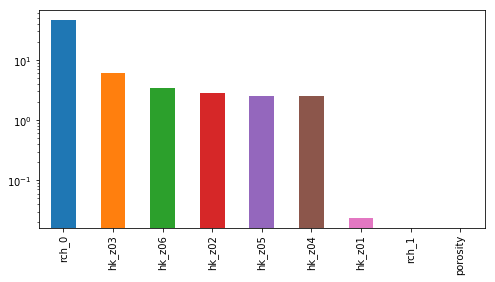

In [8]:
plt.figure(figsize=(8,4))
ax = css_df['pest_css'].sort_values(ascending=False).plot(kind='bar')
ax.set_yscale('log')

# So how do these parameter sensitivities affect the forecasts?  

###  Recall that the sensitivity is calculated by differencing the two model outputs, so any model output can have a sensitivity calculated even if we don't have a measured value.  So, because we included the forecasts as observations we have sensitivities for them in our Jacobian matrix.  Let's use pyemu to pull just these forecasts....

In [9]:
jco_fore_df = sc.forecasts.to_dataframe()
jco_fore_df

,travel_time,fa_headwaters_0001,c001fr16c17_19791231,c001fr05c04_19791231
hk_z01,34.711184,-2.846317,-0.000463,-0.039339
hk_z02,2758.382079,3.517400,-0.044199,-6.428511
hk_z03,-3290.620232,161.638413,-0.032860,-9.500682
hk_z04,684.967362,386.913996,-0.728241,-1.397704
hk_z05,-17182.036022,157.241663,-0.082150,-0.520668
hk_z06,-12220.650806,63.081792,-0.044199,-0.394319
porosity,34158.119021,0.000000,0.000000,0.000000
rch_0,-2300.194452,-2952.255612,1.005004,16.014352
rch_1,-5551.475342,-2235.701072,1.198924,3.984150


## Note that porosity is 0.000 except for the travel time forecast, which makes sense.  

### Perhaps less obvious is rch_0 - why does it have sensitivity when all the forecasts are in the period that has rch_1 recharge? 

### Now let's consider posterior covariance 

In [11]:
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,hk_z01,hk_z02,hk_z03,hk_z04,hk_z05,hk_z06,porosity,rch_0,rch_1
hk_z01,1.106455e-01,9.856213e+00,1.213592e+01,3.646762e+00,3.293942e+00,2.860211e+00,0.0,-3.558251e+01,4.058052e-50
hk_z02,9.856213e+00,1.575777e+03,3.009792e+03,5.611964e+02,3.103760e+02,2.598595e+02,0.0,-6.364436e+03,6.583611e-49
hk_z03,1.213592e+01,3.009792e+03,7.192978e+03,1.615751e+03,9.477216e+02,8.333573e+02,0.0,-1.674303e+04,2.182646e-48
hk_z04,3.646762e+00,5.611964e+02,1.615751e+03,1.208776e+03,1.127399e+03,1.174966e+03,0.0,-1.217063e+04,-1.745170e-47
hk_z05,3.293942e+00,3.103760e+02,9.477216e+02,1.127399e+03,1.277201e+03,1.362632e+03,0.0,-1.217421e+04,-2.217376e-47
hk_z06,2.860211e+00,2.598595e+02,8.333573e+02,1.174966e+03,1.362632e+03,2.387433e+03,0.0,-2.827440e+04,-8.829322e-47
porosity,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
rch_0,-3.558251e+01,-6.364436e+03,-1.674303e+04,-1.217063e+04,-1.217421e+04,-2.827440e+04,0.0,4.234475e+05,-6.391041e-46
rch_1,4.058052e-50,6.583611e-49,2.182646e-48,-1.745170e-47,-2.217376e-47,-8.829322e-47,0.0,-6.391041e-46,7.751193e-45


For covariance, very small numbers reflect that the parameter doesn't covary with another.  Does it make sense that rch_1 does not covary with other parameters?

### We can visualize the correlation betwen the two parameters using a correlation coefficient

/Users/rjhunt1/GitHub/pyemu/pyemu/mat/mat_handler.py:2678: RuntimeWarning: invalid value encountered in double_scalars
  pearson[i,j+i+1] = df.loc[iname,jname] / (std_dict[iname] * std_dict[jname])


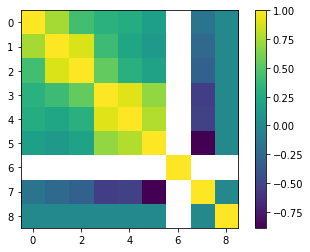

In [13]:
R = covar.to_pearson()
plt.imshow(R.df(), interpolation='nearest', cmap='viridis')
plt.colorbar()

As expected, the parameters are correlated perfectly to themselves (1.0 along the yellow diagonal) buth they also can have appreciable correlation to each other, both positively and negatively 

#### Using zone hk_z03, let's look only at the parameters that have correlation > 0.5

In [14]:
cpar = 'hk_z03'
R.df().loc[cpar][np.abs(R.df().loc[cpar])>.5]

hk_z02    0.893994
hk_z03    1.000000
hk_z04    0.547958
Name: hk_z03, dtype: float64

Saying parameters are correlated is really saying that when a parameter changes it has a similar effect on the observations as the other parameter(s). So in this case that means that when hk_z03 increases it has a similar effect on observations as increasing hk_z02.  If we add a new observation type (or less powerfully, a new location) we can break the correlation.  And we've seen this:  adding a flux observation broke the correlation between R and K!

We can use this pyemu picture to interrogate the correlation - here we say plot this but cut out all that correlations under 0.9.  Play with this by putting other numbers between -0.3 and 1.0 and re-run the block below.

/Users/rjhunt1/miniconda3/envs/ppp/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


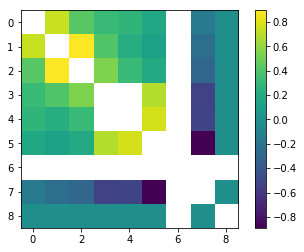

In [15]:
R_plot = R.df().as_matrix().copy()
R_plot[np.abs(R_plot)>.9] = np.nan
plt.imshow(R_plot, interpolation='nearest', cmap='viridis')
plt.colorbar()

In practice, correlation >0.95 or so becomes a problem for the parameter estimation problem.  

# 2) Global Sensitivity
### Secondly, let's run GSA, a global sensitivity analysis tool.  By default (no extra settings), GSA will run the Method of Morris with 4 discretization points for each parameter (36 runs) plus the 4 new starting points from the intial conditions (4 runs). That is, 40 runs instead of the 10 needed for the local sensitivity method, so we'll use sweep.

In [16]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"gsa",pst_name,num_slaves=15,master_dir=".")
os.chdir("..")

#### Again, let's echo out the working directory in case you want to look at the files that were just created...

In [18]:
os.getcwd()

'/Users/rjhunt1/GW1876-SD18/activities/freyberg_global_sensitivity'

## GSA results

Let's look at a table and plot of the GSA results.  In this case we are looking at the mean sensitivity, and the standard deviation of the sensitivity as you change the starting value in the parameter space.  If the __mean sensitivity is high__ it shows that parameter has higher sensitivity across the parameter space.  If the __standard deviation is low__ than the linear assumptions of FOSM hold (that is, the sensitivity is the similar regardless of starting value).  

In [20]:
df = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".msn")),skipinitialspace=True)
df.loc[:,"parnme"] = df.pop("parameter_name").apply(lambda x : x.lower().replace("log(",'').replace(')',''))
df.index = df.parnme
df

,n_samples,sen_mean,sen_mean_abs,sen_std_dev,parnme
parnme,,,,,
hk_z01,4,1.500710e+01,5.916520e+01,7.937210e+01,hk_z01
hk_z02,4,8.474380e+04,8.822600e+04,1.580780e+05,hk_z02
hk_z03,4,2.770360e+05,5.878580e+05,1.004960e+06,hk_z03
hk_z04,4,-1.664470e+05,1.719360e+05,3.053300e+05,hk_z04
hk_z05,4,2.254020e+04,3.039040e+04,5.558640e+04,hk_z05
hk_z06,4,-3.666200e+04,4.911590e+04,7.248110e+04,hk_z06
porosity,4,-4.502000e-11,4.774850e-11,8.666970e-11,porosity
rch_0,4,-2.924680e+05,2.924680e+05,5.013390e+05,rch_0
rch_1,4,1.125500e-11,1.125500e-11,2.161010e-11,rch_1


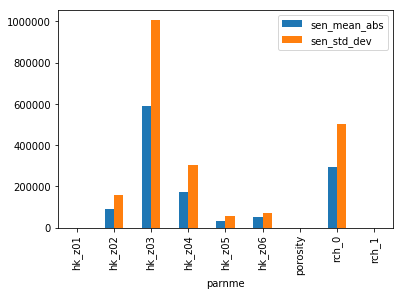

In [21]:
df.loc[:,["sen_mean_abs","sen_std_dev"]].plot(kind="bar")

### Interesting!  ``hk_z03`` is more sensitive across parameter space compared to the other HK parameters...and it and ``rch_0`` looks to be suffering from non-linearity (and/or interactions with other parameters - Method of Morris can't distinguish the two)!